In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
from os.path import isfile, join
import string
import time
import re
from string import punctuation
import sys

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.tokenize import RegexpTokenizer

from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder , StandardScaler , MaxAbsScaler 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer


import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
from keras import Sequential
from keras import metrics


def timing(f):
    def wrap(*args, **kwargs):
        time1 = time.time()
        ret = f(*args, **kwargs)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap

# Data Acquisition

In [2]:
#______________________________________________________ DATA INGESTION___________________________________________________________________
dataset = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target
label=[]
for i in df['source']:
    label.append(dataset.target_names[i])
df['label']=label
df.drop(['source'],axis=1,inplace=True)



#++++++++++++++++++++++++++++++++++++++++Macro Categories++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
key_categories = ['politics','sport','religion','computer','sales','automobile','science','medicine']
cat_dict = {
**dict.fromkeys(['talk.politics.misc','talk.politics.guns','talk.politics.mideast'],'politics'),
**dict.fromkeys( ['rec.sport.hockey','rec.sport.baseball'],'sport'),
**dict.fromkeys( ['soc.religion.christian','talk.religion.misc'],'religion'),
**dict.fromkeys(['comp.windows.x','comp.sys.ibm.pc.hardware','comp.os.ms-windows.misc','comp.graphics','comp.sys.mac.hardware'],'computer'),
**dict.fromkeys( ['misc.forsale'],'sales'),
**dict.fromkeys( ['rec.autos','rec.motorcycles'],'automobile'),
**dict.fromkeys( ['sci.crypt','sci.electronics','sci.space'],'science'),
**dict.fromkeys( ['sci.med'],'medicine') 
}
df['label']=df['label'].map(cat_dict)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

label_encoder = LabelEncoder()  
# Encode labels in column 
df['target']= label_encoder.fit_transform(df['label'])

df = df.sample(frac = 1)
# dependent and independent variable
X = df['text']
y = df['target']

df['label'].value_counts()
#_____________________________________________________________________________________________________________________________________________

computer      2936
science       1779
politics      1575
sport         1197
automobile    1192
religion       976
medicine       594
sales          585
Name: label, dtype: int64

In [3]:
df['label'].value_counts()

computer      2936
science       1779
politics      1575
sport         1197
automobile    1192
religion       976
medicine       594
sales          585
Name: label, dtype: int64

### Downsampling Data

In [4]:
def downsample(df):
    minority_frequency  = df['label'].value_counts()[-1]
    minority_label = df['label'].value_counts().index[-1]
    
    df_balanced = df.loc[df['label'] == minority_label , : ].sample(minority_frequency).copy()
    df_balanced = df_balanced.reset_index(drop = True)
    
    label_list = df['label'].value_counts().index.tolist()
    #Sample and concat
    for label in label_list:
        if label != minority_label:
            sample_df = df.loc[df['label'] == label , : ].sample(minority_frequency).copy()
            df_balanced = pd.concat([ df_balanced , sample_df],axis = 0 , ignore_index=True) 
    # Shuffle data
    df_balanced = df_balanced.sample(frac = 1).reset_index(drop = True)
    
    return df_balanced

df_balanced = downsample(df)
# dependent and independent variable
X = df_balanced['text']
y = df_balanced['target']

In [5]:
# Proportions of labels
pd.DataFrame(y.value_counts()).T

,2,6,1,3,0,5,7,4
target,585,585,585,585,585,585,585,585


In [6]:
# doc  = nlp('I  @  1223 am happy for your new promotion')
# tokens_list  = [ token for token in doc if not token.is_punct and not token.is_space and token.is_alpha]
# filter_token_sw = [token.lemma_ for token in tokens_list if token.lower_ not in stopwords.words('english')]
# filter_token_sw

# Preprocessing Pipeline

In [7]:

#Need OPT
def spacy_preprocessing(text_format):
        
    def combine_text(list_of_text):
            combined_text = ' '.join(list_of_text)
            return combined_text
        
    doc  = nlp(text_format)
    tokens_list  = [ token for token in doc if not token.is_punct and not token.is_space and token.is_alpha]
    filter_token_sw = [token.lemma_ for token in tokens_list if token.lower_ not in stopwords.words('english')]
   
    return combine_text(filter_token_sw)
    
vec_prop = np.vectorize(spacy_preprocessing)
pipe_spacy_preprocessing = FunctionTransformer(vec_prop)



class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()
    

    

prep_pipeline = Pipeline([
                    ('text_preprocessing', pipe_spacy_preprocessing )
                    ])

# DEFINE LABELS IN OHE FORMAT
yc = tf.keras.utils.to_categorical(y,num_classes = 20,dtype=int )

In [8]:
X.shape

(4680,)

# Model Pipeline

### Hyperparameters fine-tuning

In [9]:
# TF IDF DIMENSION will affect the model 
matrix_features  = 2500

n_classes =y.nunique()
def create_model(optimizer="adam",
                 dense_layer_sizes = False,
                 dropout=0.1, init='uniform',
                 features=matrix_features,neurons=20,
                 n_classes = n_classes ):
    
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(features,),kernel_initializer=init)) #
    model.add(Dropout(dropout), )    

    #for layer_size in dense_layer_sizes:
    #   model.add(Dense(layer_size, activation='relu'))
    #   model.add(Dropout(dropout), )    
    
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['sparse_categorical_accuracy'])
    return model





#dense_layer_sizes = [[] , []]
#param_grid = dict(neurons=neurons, epochs = epochs, batch_size =batch_size)

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'kc__epochs': [20],
    'kc__neurons': [10, 20, 30, 100],
    'kc__batch_size':[16, 32,50],
    'kc__dropout': [ 0.3, 0.1, 0]
}


#StratifiedKFold(n_splits=2, shuffle=True)



In [16]:
model_pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer(use_idf = True,max_features=2500)),
                    ('sparse_to_dense',DenseTransformer()),
                    ('scaler', MaxAbsScaler()),
                    ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))
])

grid = GridSearchCV(estimator=model_pipeline,
                    verbose=1,
                    cv=3,
                    param_grid=param_grid,
                    scoring='accuracy')

C:\Users\david\AppData\Local\Temp/ipykernel_24772/2774258588.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ('kc' ,KerasClassifier(build_fn=create_model, verbose = 0))


In [17]:
from sklearn import set_config
set_config(display='diagram')

grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=2500)),
                                       ('sparse_to_dense',
                                        <__main__.DenseTransformer object at 0x000001F748B15700>),
                                       ('scaler', MaxAbsScaler()),
                                       ('kc',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001F748B157C0>)]),
             param_grid={'kc__batch_size': [16, 32, 50],
                         'kc__dropout': [0.3, 0.1, 0], 'kc__epochs': [20],
                         'kc__neurons': [10, 20, 30, 100],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=1)

#### Grid Search 

In [12]:
# limit = 100
# X_p = prep_pipeline.fit_transform(X[:limit]).toarray()
# X_p.shape

In [13]:
# from sklearn.utils.multiclass import type_of_target
# type_of_target(y) , type_of_target(yc)

In [14]:
X_t = prep_pipeline.fit_transform(X)

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

t0 = time.time()
grid_fitted = grid.fit(X_t,y) # Pipe line fitted with preprocessed clean text spacy
results  =  pd.DataFrame(grid_fitted.cv_results_).sort_values('rank_test_score')

t1 = time.time()
delta = t1-t0
print(f'Tuning Time s: {delta}')
results.head()

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Tuning Time s: 940.1412997245789


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kc__batch_size,param_kc__dropout,param_kc__epochs,param_kc__neurons,param_tfidf__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
50,2.537668,0.263554,0.352414,0.039332,50,0.3,20,20,"(1, 1)","{'kc__batch_size': 50, 'kc__dropout': 0.3, 'kc...",0.737821,0.767308,0.743590,0.749573,0.012760,1
64,2.268444,0.051713,0.341592,0.016804,50,0,20,10,"(1, 1)","{'kc__batch_size': 50, 'kc__dropout': 0, 'kc__...",0.733333,0.765385,0.743590,0.747436,0.013365,2
51,3.424918,0.049353,0.429415,0.014106,50,0.3,20,20,"(1, 2)","{'kc__batch_size': 50, 'kc__dropout': 0.3, 'kc...",0.729487,0.760897,0.751282,0.747222,0.013141,3
56,2.490944,0.134261,0.378351,0.048301,50,0.1,20,10,"(1, 1)","{'kc__batch_size': 50, 'kc__dropout': 0.1, 'kc...",0.730769,0.765385,0.742308,0.746154,0.014391,4
58,2.433250,0.026338,0.345198,0.007049,50,0.1,20,20,"(1, 1)","{'kc__batch_size': 50, 'kc__dropout': 0.1, 'kc...",0.724359,0.767949,0.746154,0.746154,0.017795,4


In [21]:
grid_fitted = grid_results


{'kc__batch_size': 50,
 'kc__dropout': 0.3,
 'kc__epochs': 20,
 'kc__neurons': 20,
 'tfidf__ngram_range': (1, 1)}

## Fit the Pipeline

In [ ]:
# TEST SAMPLE
limit = 1000

model = create_model(neurons=20)
model.summary()

In [25]:
#+++++++++++++++++++++++ BEST PIPE PARAMS ++++++++++++++++++++++++++++++++
opt_pipeline  = grid_fitted.best_estimator_

t0 = time.time()
fitted_pipe = opt_pipeline.fit(X,y)
time.time() - t0 

3.181973695755005

# Testing Pipeline

In [34]:
dataset = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df = pd.DataFrame()
df['text'] = dataset.data
df['source'] = dataset.target
label=[]
for i in df['source']:
    label.append(dataset.target_names[i])
df['label']=label
df.drop(['source'],axis=1,inplace=True)

#++++++++++++++++++++++++++++++++++++++++Macro Categories++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
key_categories = ['politics','sport','religion','computer','sales','automobile','science','medicine']
cat_dict = {
**dict.fromkeys(['talk.politics.misc','talk.politics.guns','talk.politics.mideast'],'politics'),
**dict.fromkeys( ['rec.sport.hockey','rec.sport.baseball'],'sport'),
**dict.fromkeys( ['soc.religion.christian','talk.religion.misc'],'religion'),
**dict.fromkeys(['comp.windows.x','comp.sys.ibm.pc.hardware','comp.os.ms-windows.misc','comp.graphics','comp.sys.mac.hardware'],'computer'),
**dict.fromkeys( ['misc.forsale'],'sales'),
**dict.fromkeys( ['rec.autos','rec.motorcycles'],'automobile'),
**dict.fromkeys( ['sci.crypt','sci.electronics','sci.space'],'science'),
**dict.fromkeys( ['sci.med'],'medicine') 
}
df['label']=df['label'].map(cat_dict)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


label_encoder = LabelEncoder()  
# Encode labels in column 'species'.
df['target']= label_encoder.fit_transform(df['label'])


#++++++++++++++++++++++++ PICK RANDOM 30 % OF TEST++++++++++++++++++++++++++
df = df.sample(frac = 1) 
# dependent and independent variable
X_test = df['text']
y_test = df['target']
#_____________________________________________________________________________________________________________________________________________

In [35]:
X_test.shape

(7532,)

In [36]:
y_pred  = opt_pipeline.predict(X_test)

In [37]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.53      0.73      0.62       794
           1       0.85      0.73      0.79      1955
           2       0.56      0.71      0.62       396
           3       0.70      0.69      0.69      1050
           4       0.54      0.74      0.62       649
           5       0.60      0.81      0.69       390
           6       0.66      0.58      0.62      1183
           7       0.83      0.79      0.81       796
           8       0.00      0.00      0.00       319

    accuracy                           0.68      7532
   macro avg       0.58      0.64      0.61      7532
weighted avg       0.67      0.68      0.67      7532



c:\users\david\desktop\universityprojects\uni_venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\david\desktop\universityprojects\uni_venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\david\desktop\universityprojects\uni_venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

<AxesSubplot:>

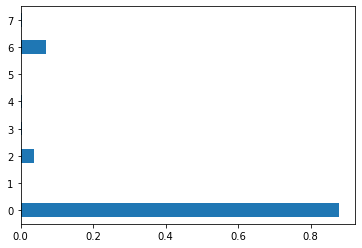

In [33]:
dist_proba_pred = pd.DataFrame(fitted_pipe.predict_proba(X_test))
dist_proba_pred.iloc[1].plot(kind ='barh')